In [1]:
import scanpy as sc
import decoupler as dc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

In [3]:
ANNO_COL = "celltypist"
GROUPs_COL = "group"
CTROL = "CCL"
STIM = "LCL"
fig_dir = "."
table_dir = "."
heatmap_fig_path = "xx.pdf"
gsva_csv = f"{table_dir}/xx.csv"
test_csv_sig = "xxx-significant.csv"

In [4]:
ANNO_COL = "celltypist"
GROUPs_COL = "group"
CTROL = "CCL"
STIM = "LCL"
adata = sc.read(
    "../../results/adata_raw_CCL_LCL/anndata_annotation_harmony_celltypist.h5ad"
)
adata

AnnData object with n_obs × n_vars = 71320 × 2000
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine'

In [5]:
adata.obs.group.unique()

['LCL', 'CCL']
Categories (2, object): ['CCL', 'LCL']

In [6]:
""" 
    - 需要原始数据raw,格式也需要处理
"""

import numpy as np
from scipy.sparse import csc_matrix

## 这里只支持csr稀疏矩阵，不支持csc稀疏矩阵
raw = adata.raw.to_adata()
raw.X = adata.raw.X.astype(np.float32).tocsr().toarray()
adata.raw = raw.copy()
adata

AnnData object with n_obs × n_vars = 71320 × 2000
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine'

In [7]:
# Retrieving via python
msigdb = dc.get_resource("MSigDB")
msigdb["collection"].unique().tolist()
# Get reactome pathways
hallmark = msigdb.query("collection == 'hallmark'")
# Filter duplicates
hallmark = hallmark[~hallmark.duplicated(("geneset", "genesymbol"))]

In [10]:
hallmark.head()

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT


In [11]:
hallmark.to_csv("../../resources/MSigDB-hallmark.csv",index=False)

In [9]:
# 这玩意不支持稀疏矩阵
dc.run_gsva(
    mat=adata,
    net=hallmark,
    source="geneset",
    target="genesymbol",
    use_raw=True,
    seed=123,
    # kcdf="poisson",  # 重现R的原始行为
    min_n=10,
    mx_diff=True,
    abs_rnk=True,
    # weight="weight",
    verbose=False,
)
adata

KeyboardInterrupt: 

In [ ]:
adata.obsm["gsva_estimate"].to_csv(gsva_csv,index=False)
adata.obsm["gsva_estimate"].head()

NameError: name 'gsva_csv' is not defined

In [ ]:
# 这里不使用copy，更改直接反应到adata，不小心重复运行不稳键
estimates = adata.obsm["gsva_estimate"].copy()
# 为列名添加前缀 "path"
estimates.columns = [col for col in estimates.columns]
estimates.columns.to_list()

['HALLMARK_ADIPOGENESIS',
 'HALLMARK_ALLOGRAFT_REJECTION',
 'HALLMARK_ANDROGEN_RESPONSE',
 'HALLMARK_ANGIOGENESIS',
 'HALLMARK_APICAL_JUNCTION',
 'HALLMARK_APICAL_SURFACE',
 'HALLMARK_APOPTOSIS',
 'HALLMARK_BILE_ACID_METABOLISM',
 'HALLMARK_CHOLESTEROL_HOMEOSTASIS',
 'HALLMARK_COAGULATION',
 'HALLMARK_COMPLEMENT',
 'HALLMARK_DNA_REPAIR',
 'HALLMARK_E2F_TARGETS',
 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
 'HALLMARK_ESTROGEN_RESPONSE_EARLY',
 'HALLMARK_ESTROGEN_RESPONSE_LATE',
 'HALLMARK_FATTY_ACID_METABOLISM',
 'HALLMARK_G2M_CHECKPOINT',
 'HALLMARK_GLYCOLYSIS',
 'HALLMARK_HEDGEHOG_SIGNALING',
 'HALLMARK_HEME_METABOLISM',
 'HALLMARK_HYPOXIA',
 'HALLMARK_IL2_STAT5_SIGNALING',
 'HALLMARK_IL6_JAK_STAT3_SIGNALING',
 'HALLMARK_INFLAMMATORY_RESPONSE',
 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
 'HALLMARK_KRAS_SIGNALING_DN',
 'HALLMARK_KRAS_SIGNALING_UP',
 'HALLMARK_MITOTIC_SPINDLE',
 'HALLMARK_MTORC1_SIGNALING',
 'HALLMARK_MYC_TARGETS_V1',
 'HALLMARK_MYC

In [ ]:
# adata.obs[estimates.columns.to_list()] = estimates
# sc.pl.umap(
#     adata,
#     color=[ANNO_COL] + estimates.columns.to_list(),
#     frameon=False,
#     ncols=5,
#     wspace=0.3,
#     vmax="p99",
#     vmin=0,
#     save="-19-单细胞GSVA.pdf",
# )

In [ ]:
# %%capture

# # Loop through each column in 'estimates'
# for column in estimates.columns:
#     # Copy the original data to avoid modifying it
#     adata_copy = adata.copy()
#     # Assign the current column as the color
#     sc.pl.umap(
#         adata_copy,
#         color=column,
#         frameon=False,
#         ncols=5,
#         wspace=0.3,
#         vmax="p99",
#         vmin=0,
#         save=f"-19-GSVA-{column}.pdf",
#     )

In [ ]:
## 转换成基因集评分矩阵
acts = dc.get_acts(adata, obsm_key="gsva_estimate")
acts

AnnData object with n_obs × n_vars = 71320 × 50
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine', 

In [ ]:
acts.obs

,C0,orig.ident,nCount_RNA,nFeature_RNA,nCount_antibody,nFeature_antibody,patients,sampletag,organs,percent.mt,...,doublet_score,predicted_doublet,leiden,leiden_0_25,leiden_0_5,leiden_1,leiden_2,celltypist_cell_label_fine,celltypist_conf_score_fine,celltypist
1122,s0920_SampleTag08-830780s8-3_4,s0920,3009,1448,0,0,s0920,s0920_SampleTag08-3_4,LCL,5.782652,...,0.047022,False,1,0,0,1,0,T cells,0.924354,T cells
1236,s0920_SampleTag06-91522s8-3_4,s0920,3014,1017,0,0,s0920,s0920_SampleTag06-3_4,CCL,13.536828,...,0.307692,False,5,3,3,6,9,Macrophages,0.469342,Macrophages
1242,s0920_SampleTag06-302708s8-3_4,s0920,2974,1319,0,0,s0920,s0920_SampleTag06-3_4,CCL,4.606590,...,0.060000,False,2,1,2,4,5,T cells,0.245705,T cells
1248,s0920_SampleTag08-498970s8-3_4,s0920,2950,1311,0,0,s0920,s0920_SampleTag08-3_4,LCL,8.372881,...,0.366667,False,6,1,2,4,8,T cells,0.989843,T cells
1267,s0920_SampleTag06-861780s8-3_4,s0920,2977,1034,0,0,s0920,s0920_SampleTag06-3_4,CCL,6.650991,...,0.086538,False,5,3,3,6,13,Macrophages,0.827913,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196466,s0816_SampleTag01-99639s10-2_4,s0816,503,298,4883,33,s0816,s0816_SampleTag01-2_4,LCL,16.103380,...,0.036311,False,3,0,1,5,7,T cells,0.999146,T cells
196467,s0816_SampleTag01-534535s10-2_4,s0816,411,286,4249,33,s0816,s0816_SampleTag01-2_4,LCL,7.785888,...,0.024276,False,7,1,6,9,11,T cells,0.986246,T cells
196469,s0816_SampleTag01-49980s10-2_4,s0816,396,276,2722,32,s0816,s0816_SampleTag01-2_4,LCL,6.818182,...,0.023405,False,2,1,2,4,5,T cells,0.999985,T cells
196470,s0816_SampleTag01-372836s10-2_4,s0816,462,280,4042,32,s0816,s0816_SampleTag01-2_4,LCL,19.047619,...,0.030208,False,4,2,1,3,1,T cells,0.999686,T cells


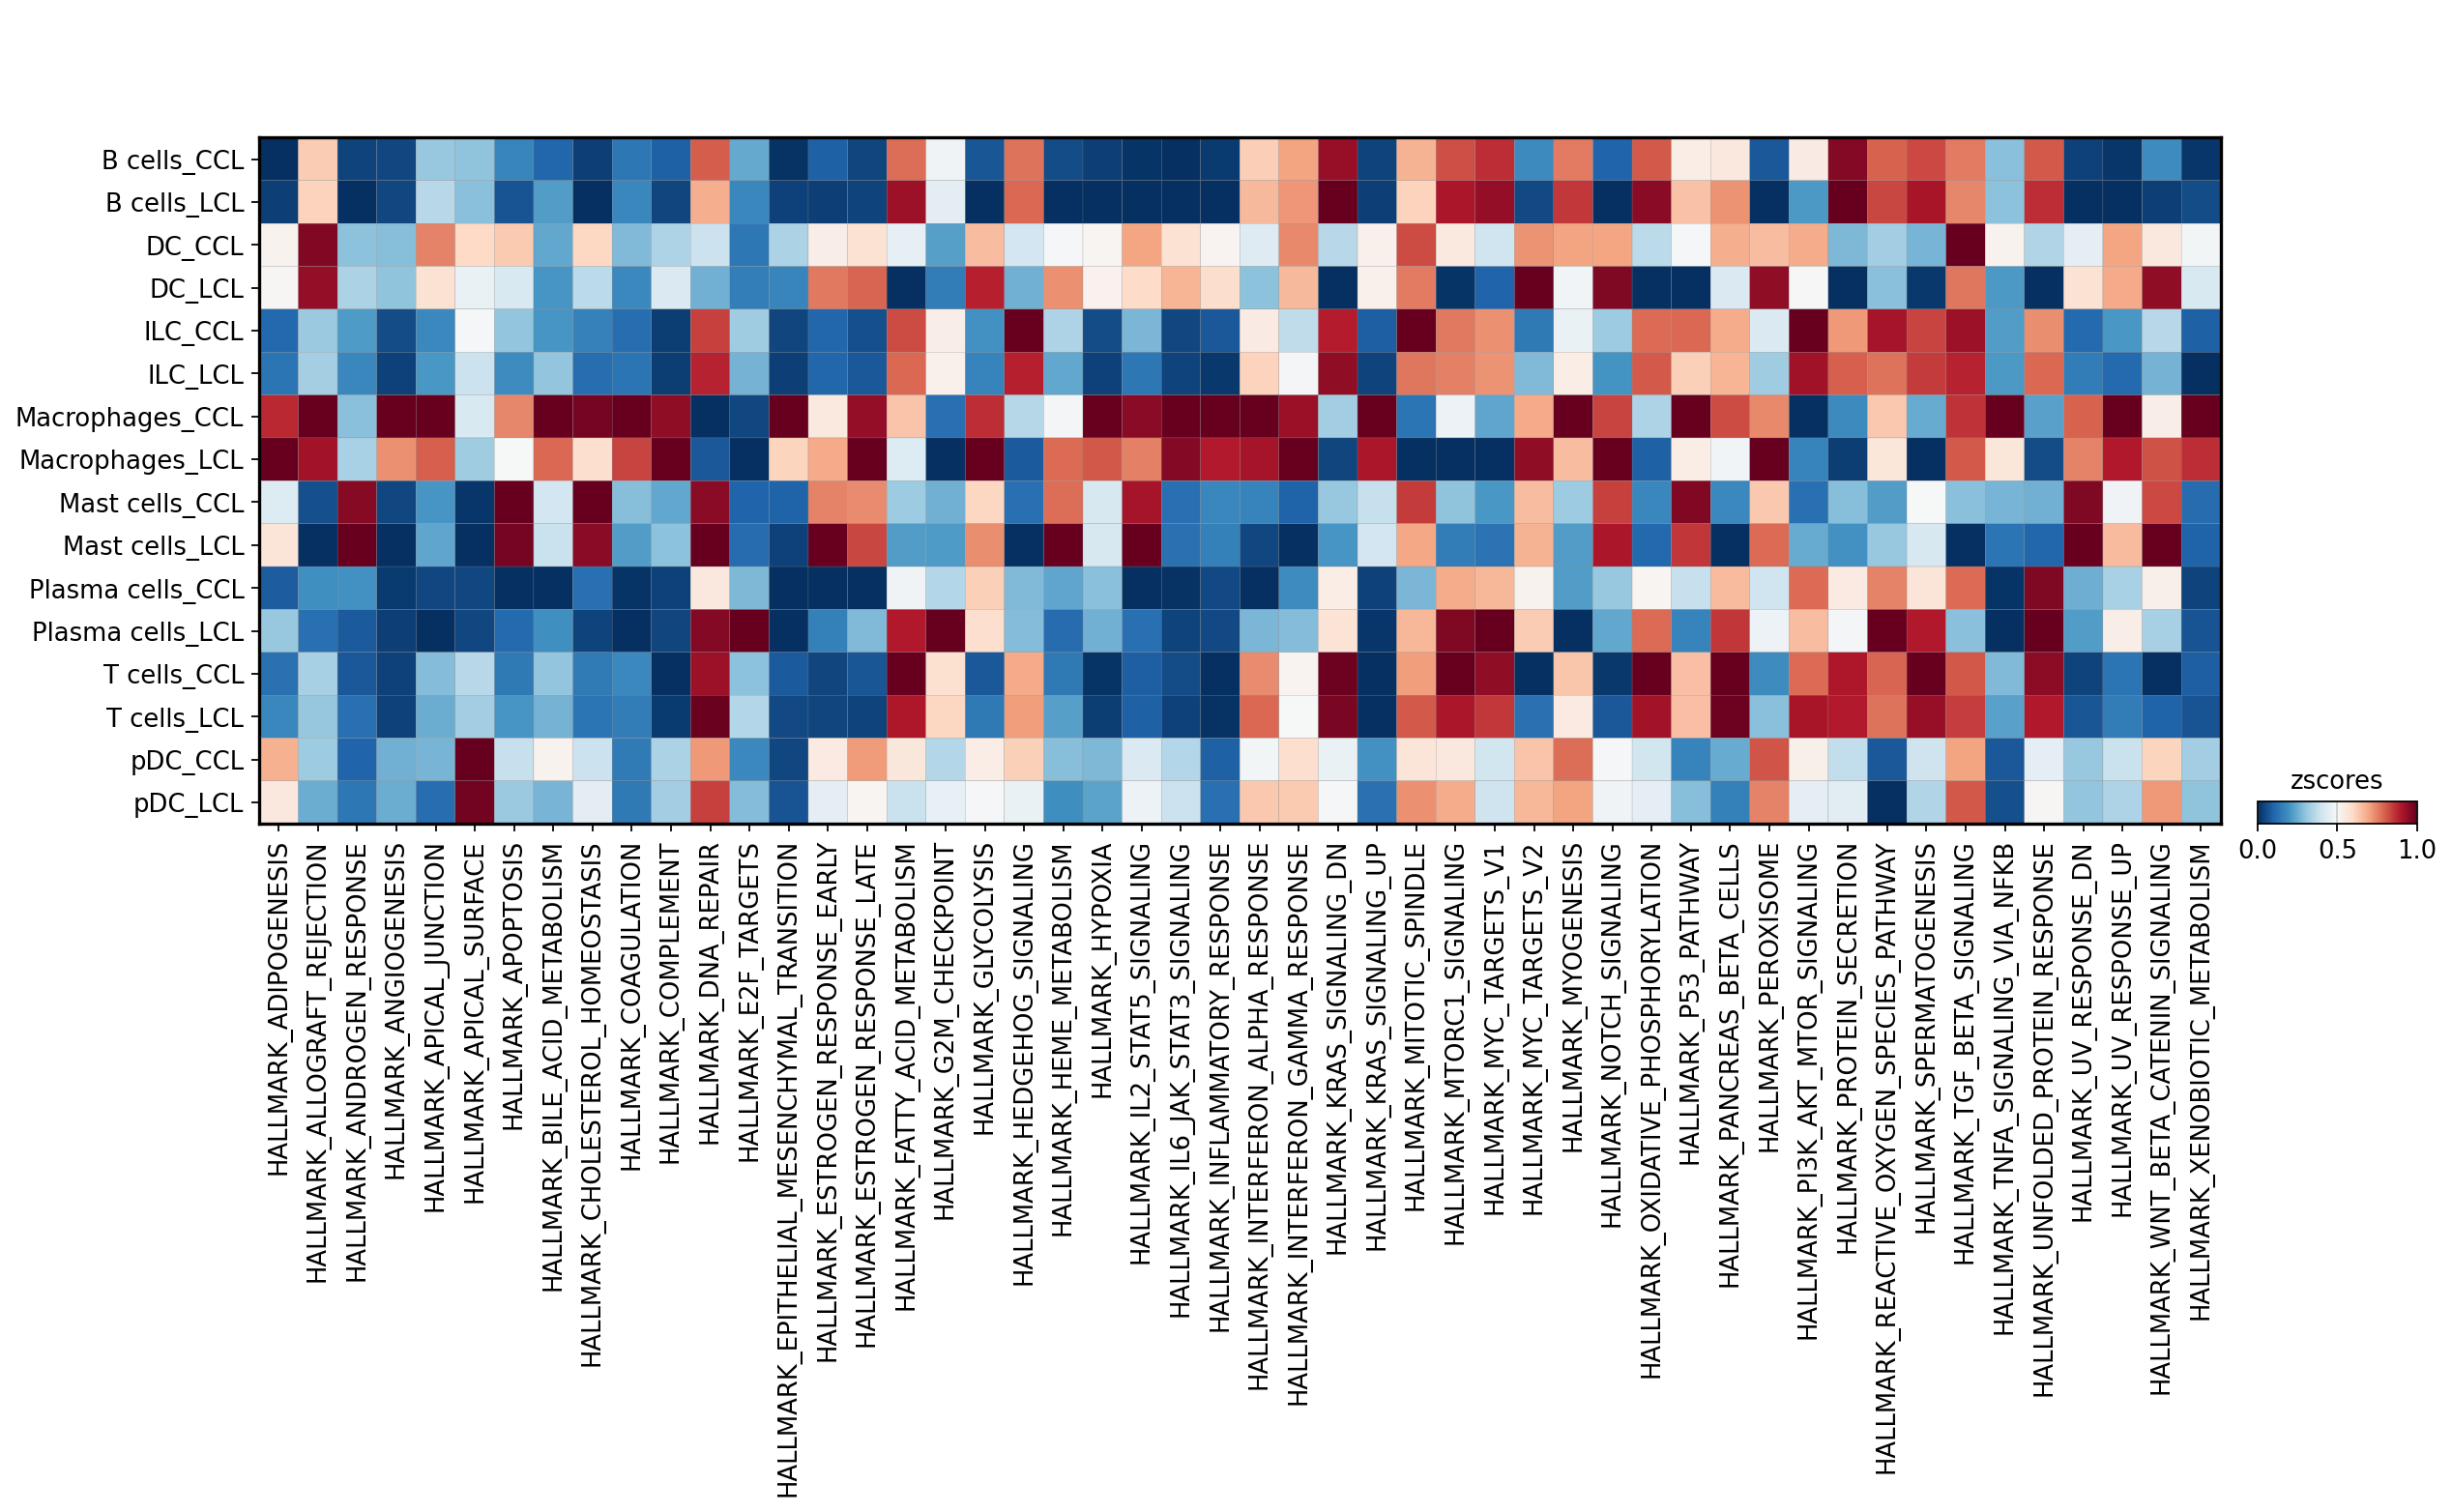

In [ ]:
# # 删除包含 "HALLMARK" 的列
# acts.obs = acts.obs.drop(columns=[col for col in acts.obs.columns if "HALLMARK" in col])

# 创建一个新的列用于分组
acts.obs["celltype_group"] = (
    acts.obs[ANNO_COL].astype(str) + "_" + acts.obs[GROUPs_COL].astype(str)
).astype("category")

# 创建一个图形和一个坐标轴
fig, ax = plt.subplots(figsize=(16, 10))

# 绘制矩阵图
sc.pl.matrixplot(
    acts,
    var_names=acts.var_names,
    groupby="celltype_group",  # 使用新的分组列
    # dendrogram=True,  # 如果需要显示树状图
    standard_scale="var",  # 标准化
    colorbar_title="zscores",  # 颜色条标题
    cmap="RdBu_r",
    show=False,
    # swap_axes=True,  # 翻转 x 和 y 轴
    ax=ax
)

plt.tight_layout()

plt.savefig(heatmap_fig_path, bbox_inches="tight")
plt.show()

In [ ]:
adata.obs[estimates.columns.to_list()] = estimates

In [ ]:
import pandas as pd

# %%
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# 用于存储结果
all_results = []

# 针对每种细胞类型循环
for cell_type in adata.obs[ANNO_COL].unique():
    try:
        # 筛选当前细胞类型的数据
        cell_data = adata.obs[adata.obs[ANNO_COL] == cell_type]

        # 针对每个途径进行检验
        for pathway in estimates.columns:
            group1_scores = cell_data.query(f"{GROUPs_COL} == '{STIM}'")[pathway]
            group2_scores = cell_data.query(f"{GROUPs_COL} == '{CTROL}'")[pathway]
            t_stat, p_val = ttest_ind(group1_scores, group2_scores, nan_policy="omit")

            # 将结果保存到列表
            all_results.append(
                {
                    "Cell_Type": cell_type,
                    "Pathway": pathway,
                    "t_stat": t_stat,
                    "p_val": p_val,
                }
            )
    except Exception as e:
        print(f"Error processing {cell_type}: {e}")

# 转换为 DataFrame
results_df = pd.DataFrame(all_results)
# FDR 校正
results_df["adj_p_val"] = multipletests(results_df["p_val"], method="fdr_bh")[1]

results_df.to_csv(test_csv, index=False)
# 筛选显著结果
significant_results = results_df[results_df["adj_p_val"] < 0.05]
significant_results.to_csv(test_csv_sig, index=False)

In [ ]:
from scipy.stats import ttest_ind


def calculate_t_test(group_a, group_b):
    """计算t检验并返回显著性标志"""
    t_stat, p_val = ttest_ind(group_a, group_b, nan_policy="omit")
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return "ns"

In [ ]:

# import matplotlib.pyplot as plt

# # %%
# import seaborn as sns

# # 定义配色方案
# palette = sns.color_palette("husl", len(adata.obs[GROUPs_COL].unique()))  # 使用husl色板

# # 按细胞类型循环
# for cell_type in adata.obs[ANNO_COL].unique():
#     try:
#         # 筛选当前细胞类型的数据
#         cell_data = adata.obs[adata.obs[ANNO_COL] == cell_type]

#         # 将数据转换为长格式
#         cell_data_melted = cell_data.melt(
#             id_vars=[GROUPs_COL],
#             value_vars=estimates.columns.to_list(),
#             var_name="Pathway",
#             value_name="gsva_estimate",
#         )

#         # 创建图形
#         plt.figure(figsize=(14, 6))

#         # 添加小提琴图
#         sns.violinplot(
#             data=cell_data_melted,
#             x="Pathway",
#             y="gsva_estimate",
#             hue=GROUPs_COL,
#             split=True,  # 分组显示
#             inner=None,  # 不显示小提琴内部的箱线
#             palette=palette,
#             alpha=0.5,  # 透明度设置
#         )

#         # 添加箱线图，去掉离群值
#         ax = sns.boxplot(
#             data=cell_data_melted,
#             x="Pathway",
#             y="gsva_estimate",
#             hue=GROUPs_COL,
#             showfliers=False,  # 不显示离群值
#             width=0.3,  # 调整箱线宽度
#             palette=palette,
#         )

#         # 避免图例重复
#         handles, labels = ax.get_legend_handles_labels()
#         ax.legend(
#             handles[: len(handles) // 2],
#             labels[: len(labels) // 2],
#             title="Group",
#             loc="upper left",
#             bbox_to_anchor=(1.01, 1),
#         )

#         # 添加显著性标记
#         pathways = estimates.columns.to_list()
#         y_max = cell_data_melted[
#             "gsva_estimate"
#         ].max()  # 取得Y轴最大值，以便放置显著性标记

#         for i, pathway in enumerate(pathways):
#             # 获取两组数据
#             group1_scores = cell_data.query(f"{GROUPs_COL} == '{STIM}'")[pathway]
#             group2_scores = cell_data.query(f"{GROUPs_COL} == '{CTROL}'")[pathway]

#             # 计算显著性标记
#             significance = calculate_t_test(group1_scores, group2_scores)

#             # 显著性标记的 x 坐标为途径位置，y 坐标为图表最大值上方偏移量
#             x = i
#             y = y_max - 0.05 * y_max  # 调整标记位置

#             # 添加显著性标记
#             ax.text(
#                 x,
#                 y,
#                 significance,
#                 ha="center",
#                 color="black",
#                 fontsize=12,
#                 fontweight="bold",
#             )

#         # 设置标题和旋转 x 轴标签
#         plt.title(f"{cell_type}")
#         plt.xticks(rotation=45)
#         plt.tight_layout()  # 调整布局避免重叠
#         plt.savefig(
#             f"{sub_fig_dir}/13-{unique_prefix}-{cell_type}-GSVA-boxplot.pdf",
#             bbox_inches="tight",
#             dpi=600,
#         )
#         plt.show()
#     except Exception as e:
#         print(f"Error processing {cell_type}: {e}")

# with open(output_file, mode="wt") as f:
#     f.write("Analysis completed successfully.")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats


def plot_gsva_violin_box(
    adata,
    estimates,
    cell_type_col,
    group_col,
    stim_group,
    control_group,
    output_dir=None,
    prefix="",
    show_significant_only=False,
    max_pathways=None,
    figsize=(14, 6),
    alpha=0.5,
    p_threshold=0.05,
):
    """
    Plot violin and box plots for GSVA results with significance filtering options.

    Parameters:
    -----------
    adata : AnnData
        Annotated data matrix
    estimates : pandas.DataFrame
        GSVA estimates
    cell_type_col : str
        Column name for cell type annotations
    group_col : str
        Column name for group assignments
    stim_group : str
        Name of treatment/stimulation group
    control_group : str
        Name of control group
    output_dir : str, optional
        Directory to save plots
    prefix : str, optional
        Prefix for output filenames
    show_significant_only : bool, optional
        Only show pathways with significant differences (default: False)
    max_pathways : int, optional
        Maximum number of pathways to display
    figsize : tuple, optional
        Figure size (width, height)
    alpha : float, optional
        Transparency for violin plots
    p_threshold : float, optional
        P-value threshold for significance
    """

    def calculate_t_test(group1, group2):
        """Calculate t-test and return significance markers"""
        _, p_value = stats.ttest_ind(group1, group2)
        if p_value >= 0.05:
            return "ns"
        elif p_value >= 0.01:
            return "*"
        elif p_value >= 0.001:
            return "**"
        else:
            return "***"

    # 定义配色方案
    palette = sns.color_palette("husl", len(adata.obs[group_col].unique()))

    # 按细胞类型循环
    for cell_type in adata.obs[cell_type_col].unique():
        try:
            # 筛选当前细胞类型的数据
            cell_data = adata.obs[adata.obs[cell_type_col] == cell_type]

            # 计算每个pathway的显著性和效应量
            pathways = estimates.columns.to_list()
            pathway_stats = []

            for pathway in pathways:
                group1_scores = cell_data.query(f"{group_col} == '{stim_group}'")[
                    pathway
                ]
                group2_scores = cell_data.query(f"{group_col} == '{control_group}'")[
                    pathway
                ]

                # 计算t检验和效应量
                t_stat, p_value = stats.ttest_ind(group1_scores, group2_scores)
                effect_size = abs(np.mean(group1_scores) - np.mean(group2_scores))

                pathway_stats.append(
                    {
                        "pathway": pathway,
                        "p_value": p_value,
                        "effect_size": effect_size,
                        "significant": p_value < p_threshold,
                    }
                )

            # 转换为DataFrame并排序
            stats_df = pd.DataFrame(pathway_stats)
            stats_df = stats_df.sort_values(
                ["significant", "effect_size"], ascending=[False, False]
            )

            # 筛选通路
            if show_significant_only:
                selected_pathways = stats_df[stats_df["significant"]][
                    "pathway"
                ].tolist()
            else:
                selected_pathways = stats_df["pathway"].tolist()

            # 限制通路数量
            if max_pathways is not None and max_pathways > 0:
                selected_pathways = selected_pathways[:max_pathways]

            if not selected_pathways:
                print(f"No significant pathways found for {cell_type}")
                continue

            # 准备绘图数据
            cell_data_melted = cell_data.melt(
                id_vars=[group_col],
                value_vars=selected_pathways,
                var_name="Pathway",
                value_name="gsva_estimate",
            )

            # 创建图形
            fig, ax = plt.subplots(figsize=figsize)

            # 添加小提琴图
            sns.violinplot(
                data=cell_data_melted,
                x="Pathway",
                y="gsva_estimate",
                hue=group_col,
                split=True,
                inner=None,
                palette=palette,
                alpha=alpha,
                ax=ax,
            )

            # 添加箱线图
            sns.boxplot(
                data=cell_data_melted,
                x="Pathway",
                y="gsva_estimate",
                hue=group_col,
                showfliers=False,
                width=0.3,
                palette=palette,
                ax=ax,
            )

            # 避免图例重复
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(
                handles[: len(handles) // 2],
                labels[: len(labels) // 2],
                title="Group",
                loc="upper left",
                bbox_to_anchor=(1.01, 1),
            )

            # 添加显著性标记
            y_max = cell_data_melted["gsva_estimate"].max()

            for i, pathway in enumerate(selected_pathways):
                group1_scores = cell_data.query(f"{group_col} == '{stim_group}'")[
                    pathway
                ]
                group2_scores = cell_data.query(f"{group_col} == '{control_group}'")[
                    pathway
                ]

                significance = calculate_t_test(group1_scores, group2_scores)

                x = i
                y = y_max - 0.01 * y_max

                ax.text(
                    x,
                    y,
                    significance,
                    ha="center",
                    color="black",
                    fontsize=12,
                    fontweight="bold",
                )

            # 设置标题
            plt.title(f"{cell_type}")

            # 修复x轴标签对齐
            ax.set_xticks(range(len(selected_pathways)))
            ax.set_xticklabels(selected_pathways, rotation=45, ha="right")

            # 调整布局以确保标签可见
            plt.tight_layout()

            # 微调底部边距，确保旋转的标签完全可见
            plt.subplots_adjust(bottom=0.2)

            # 保存图形
            if output_dir:
                plt.savefig(
                    f"{output_dir}/13-{prefix}-{cell_type}-GSVA-boxplot.pdf",
                    bbox_inches="tight",
                    dpi=600,
                )

            plt.show()
            plt.close()

        except Exception as e:
            print(f"Error processing {cell_type}: {e}")

In [ ]:
unique_prefix ="."

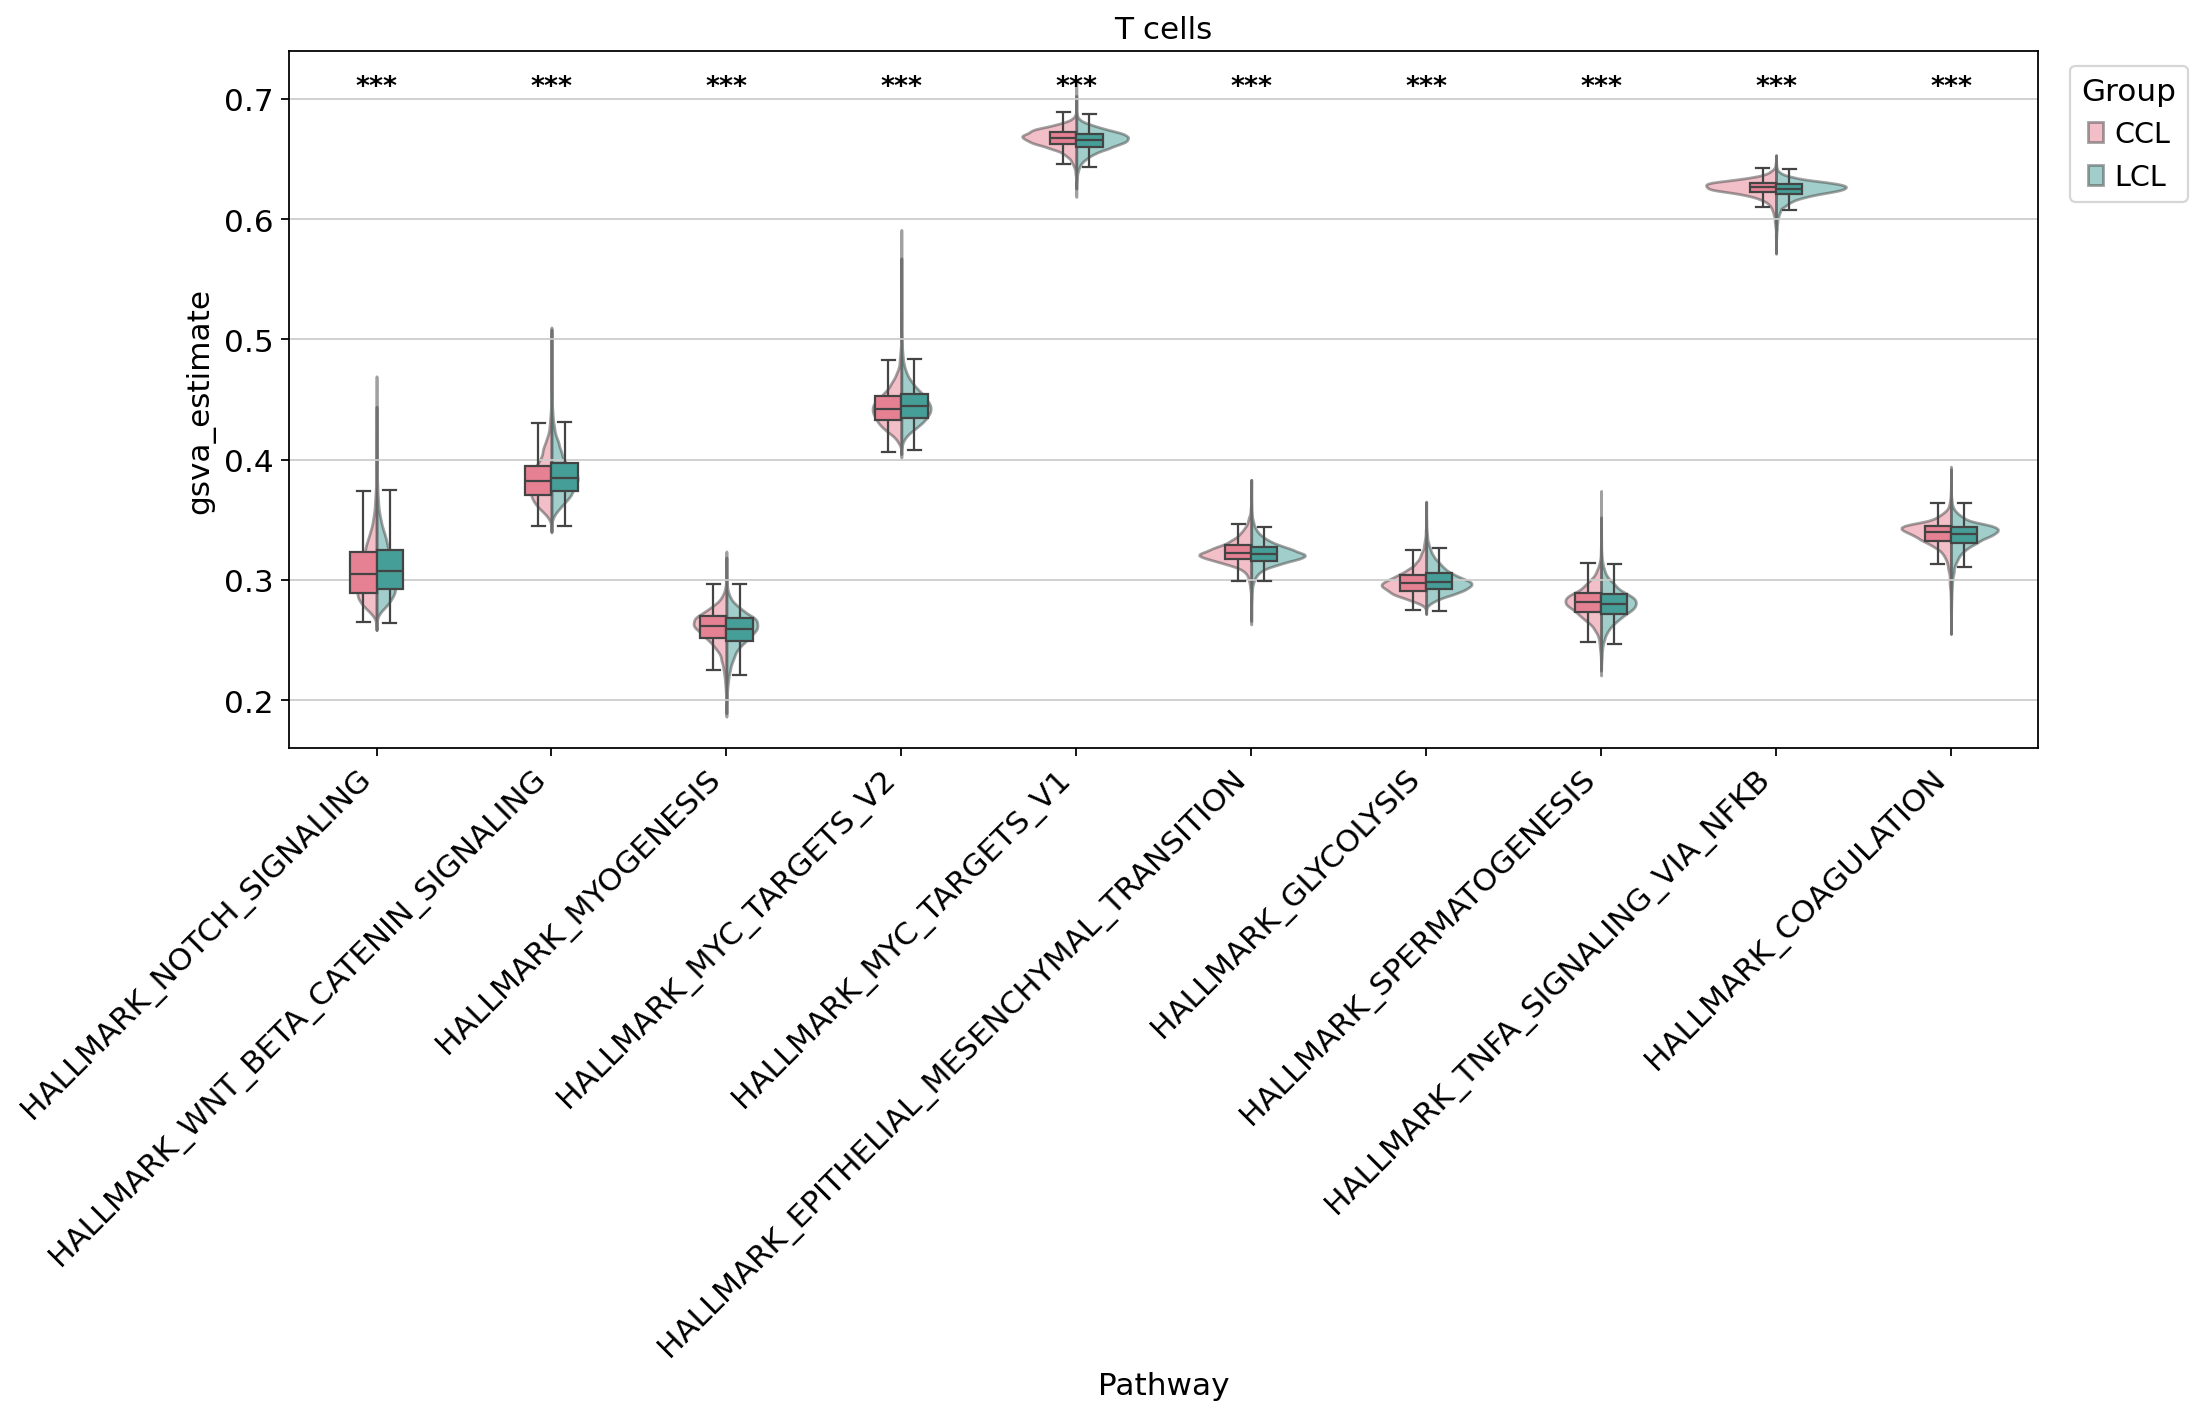

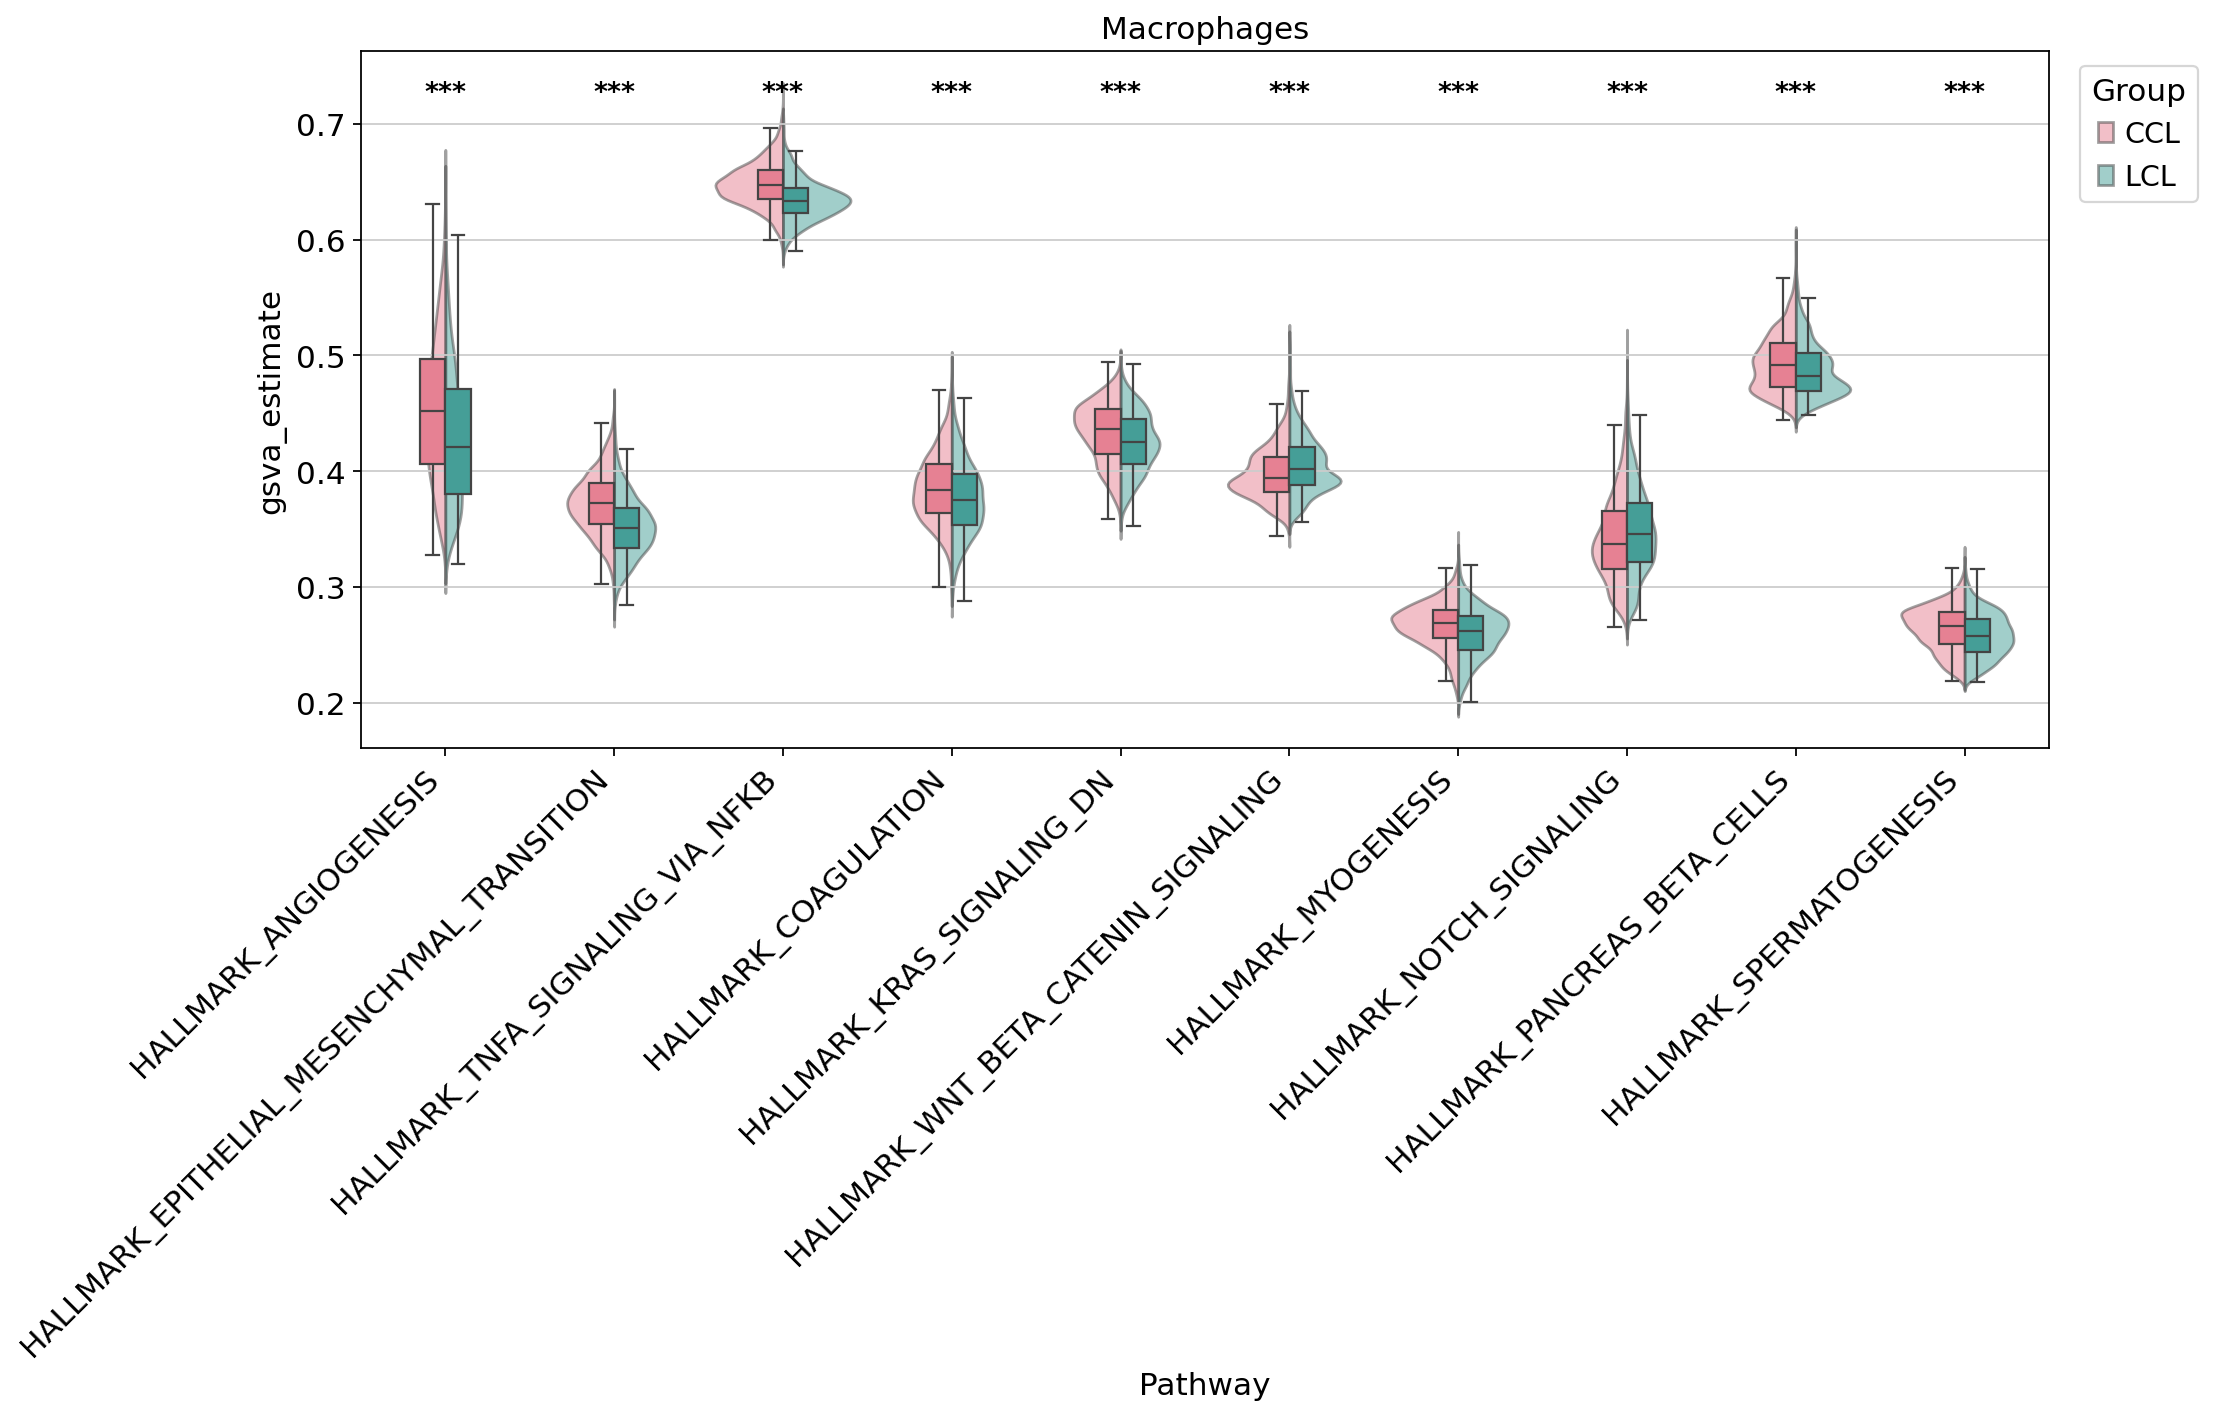

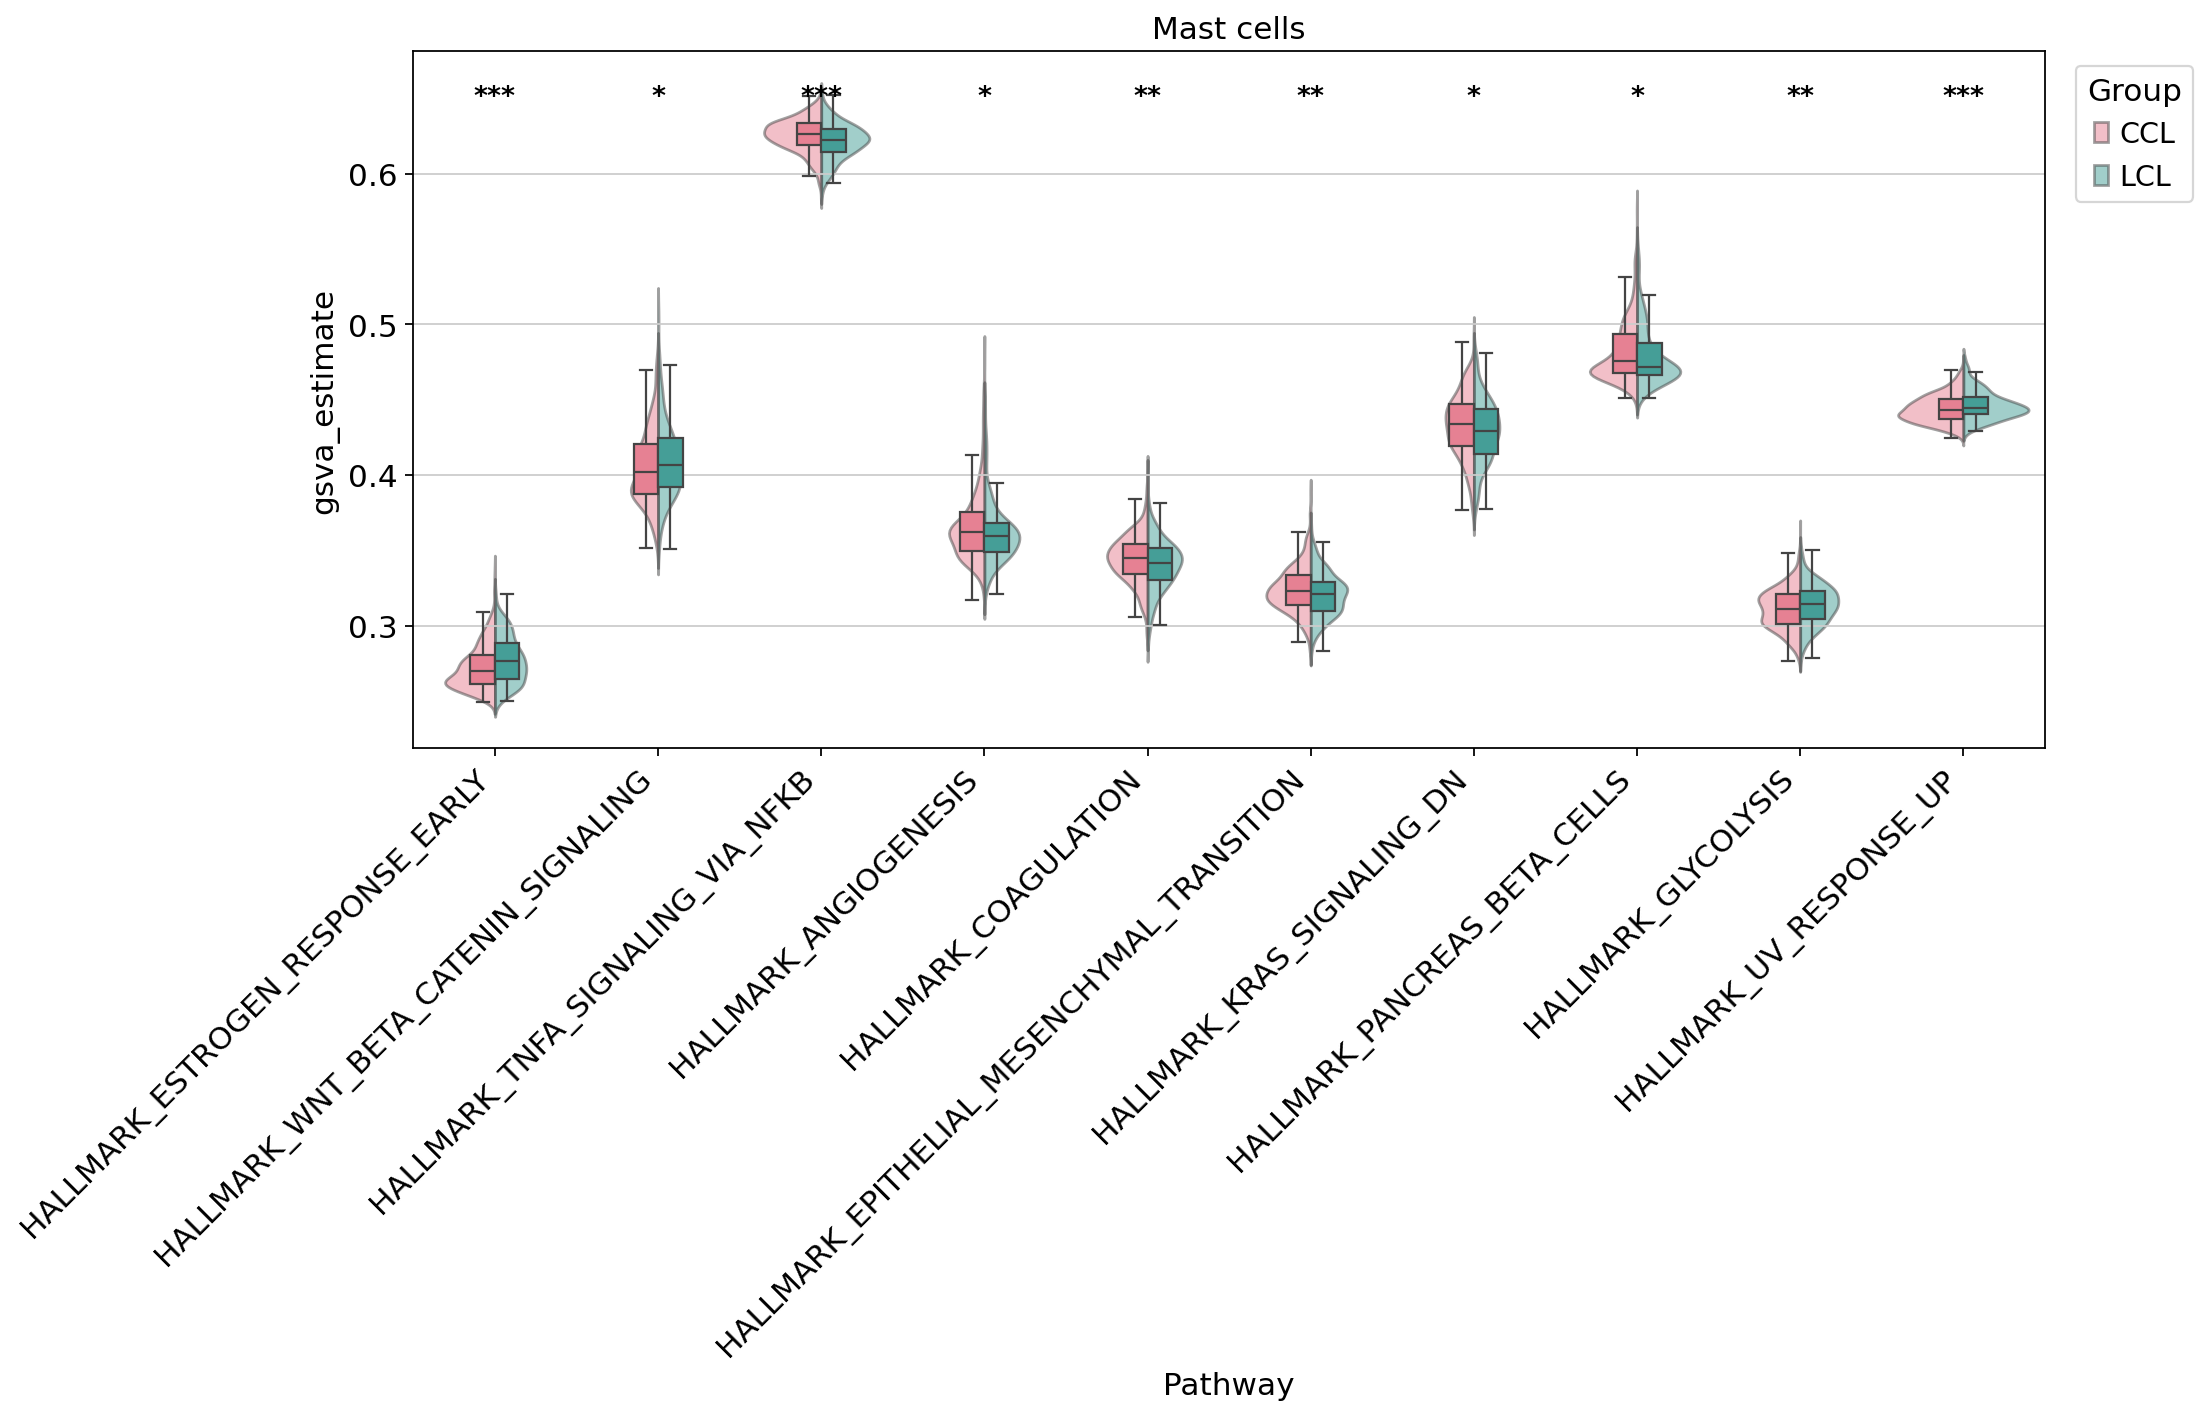

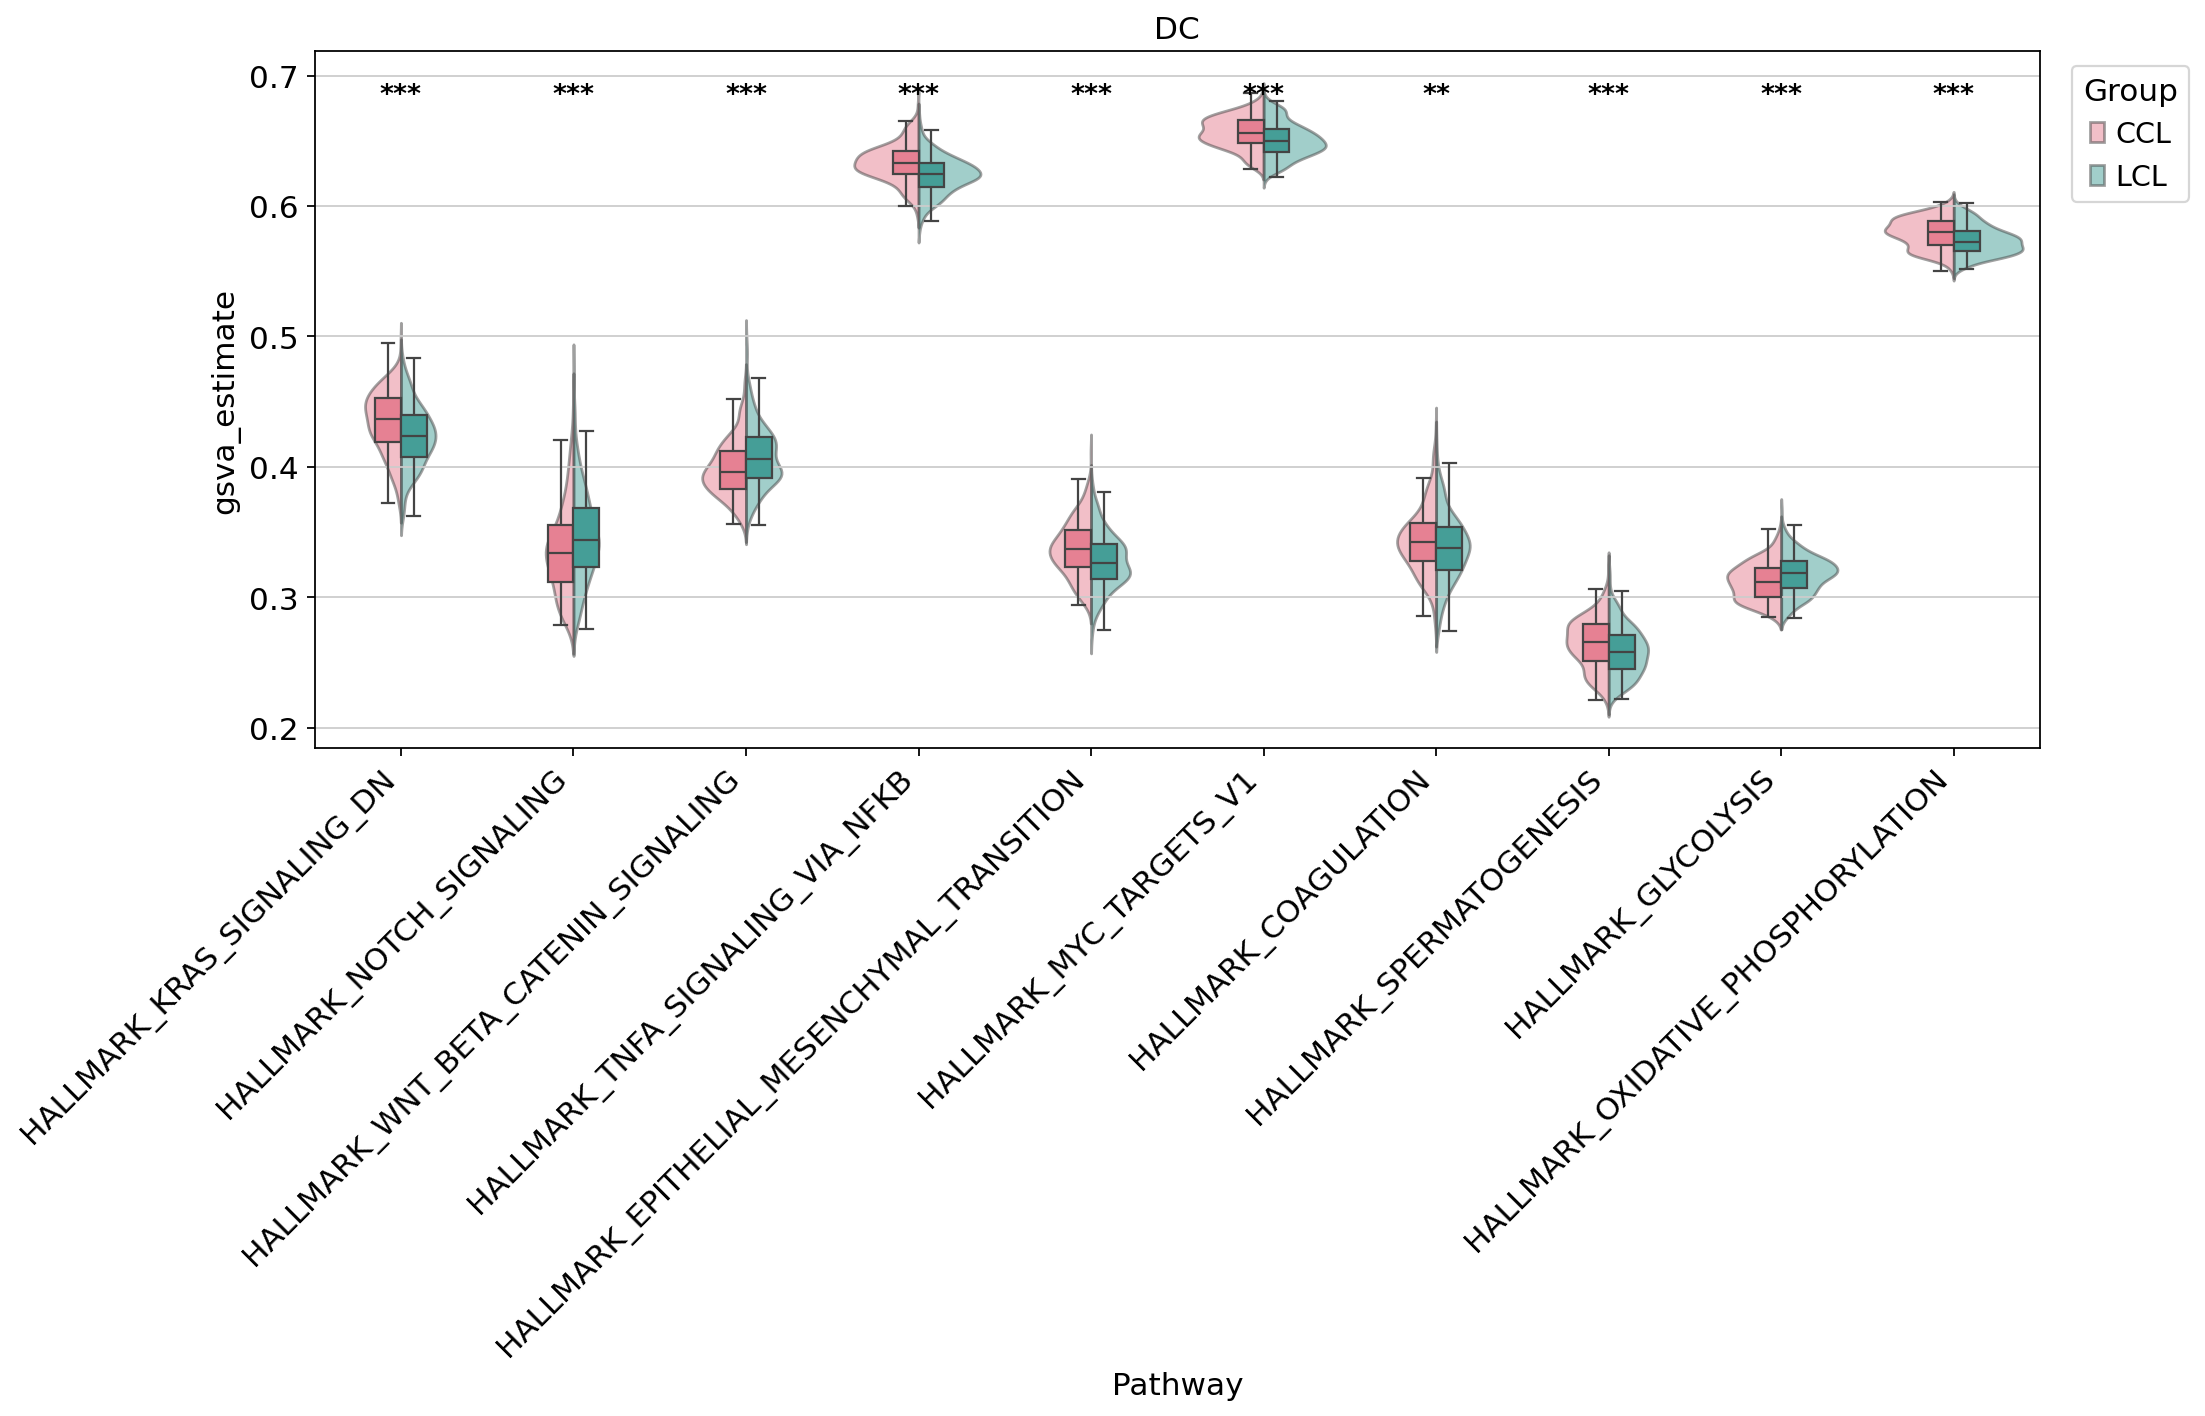

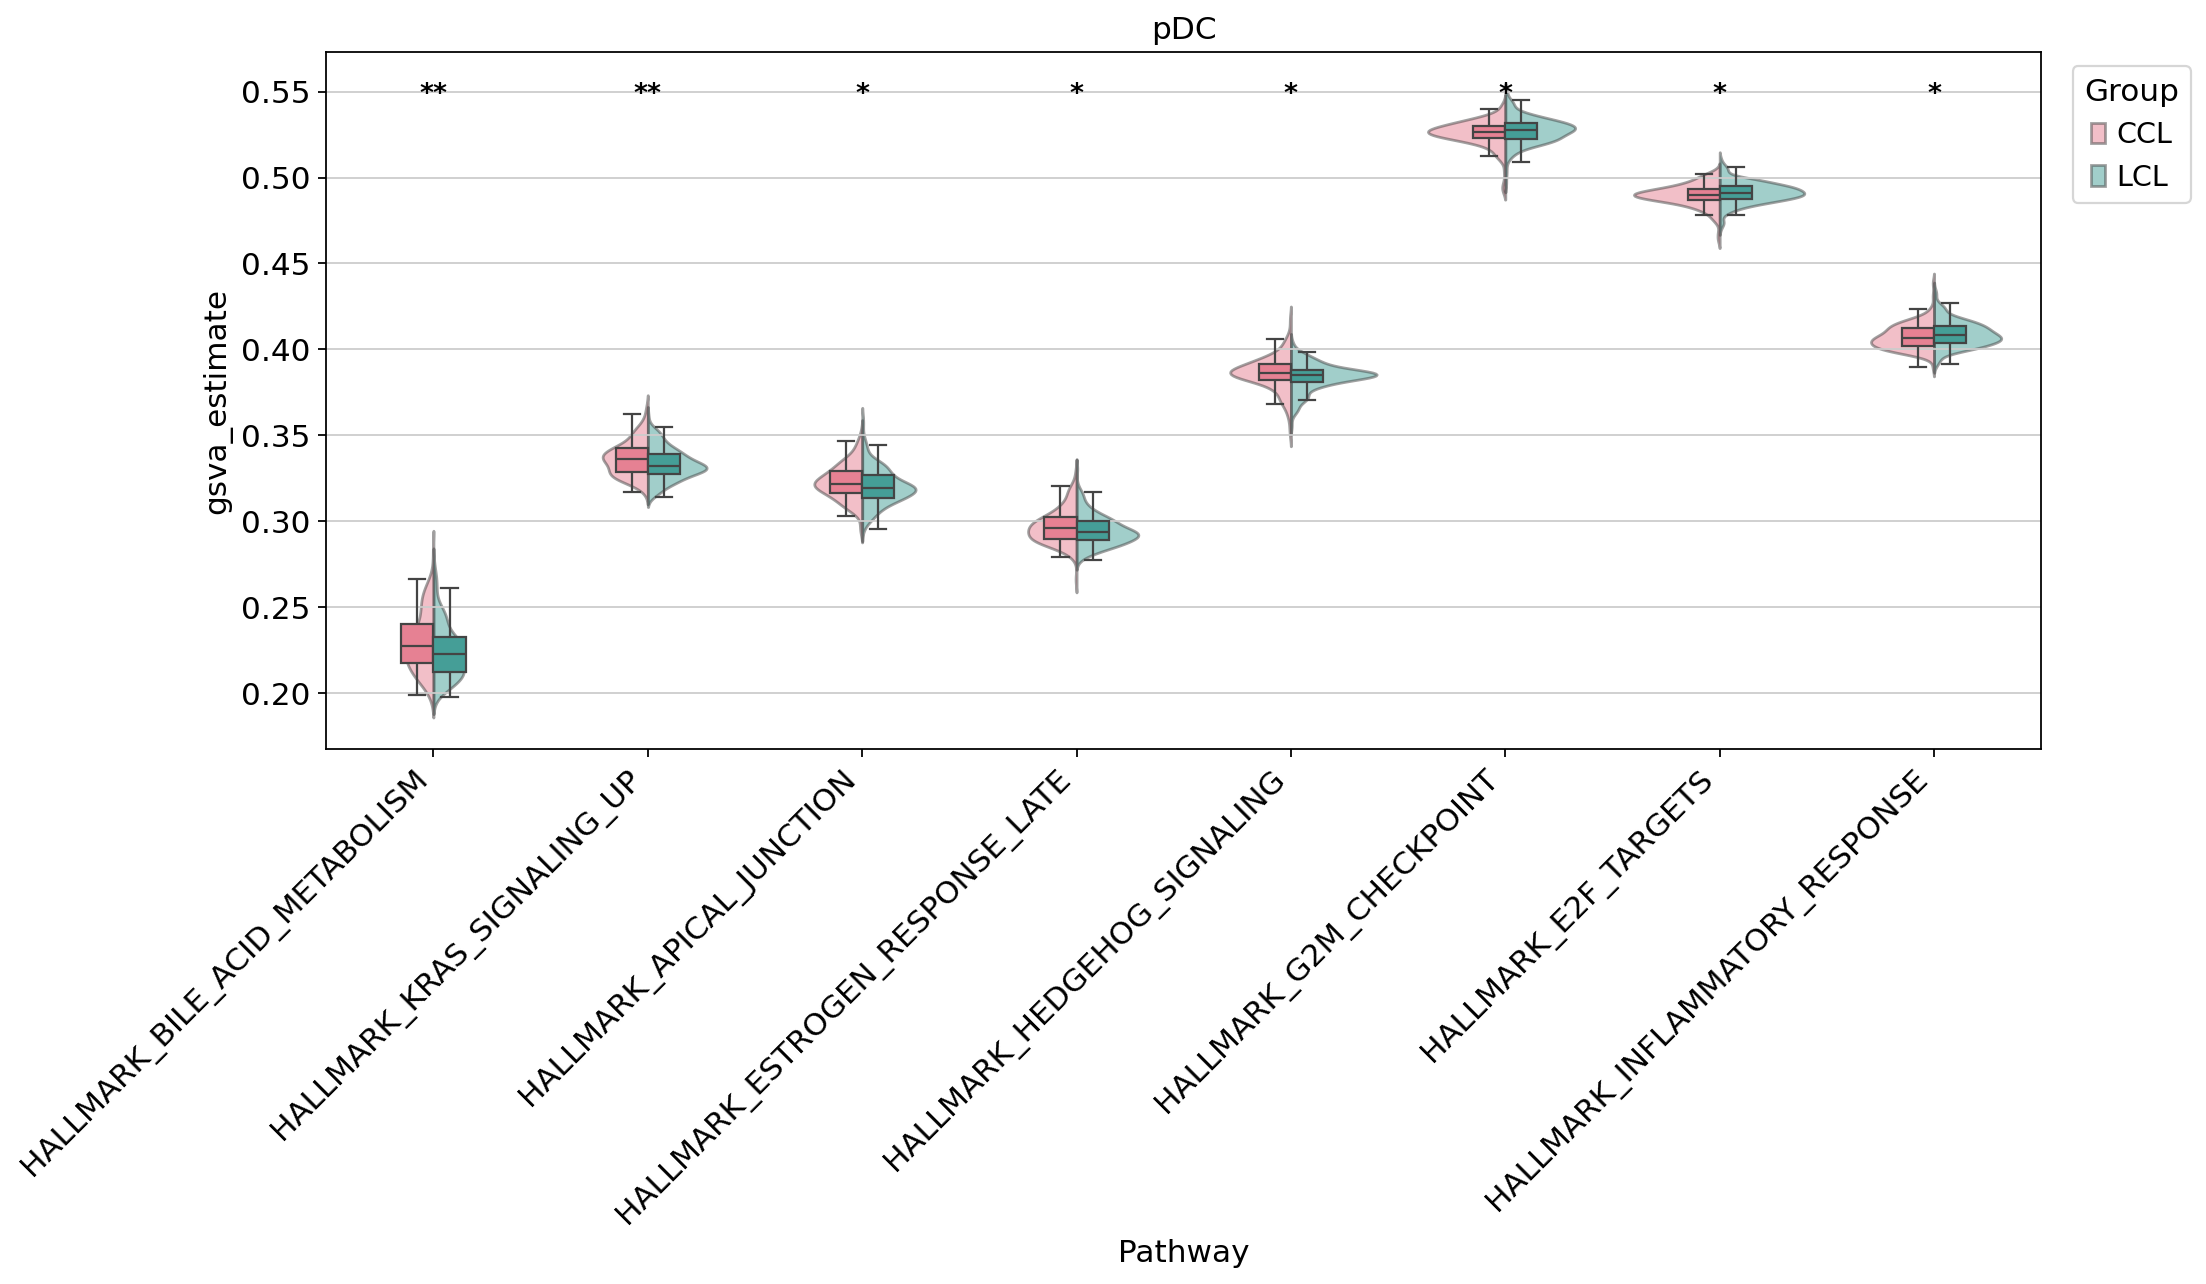

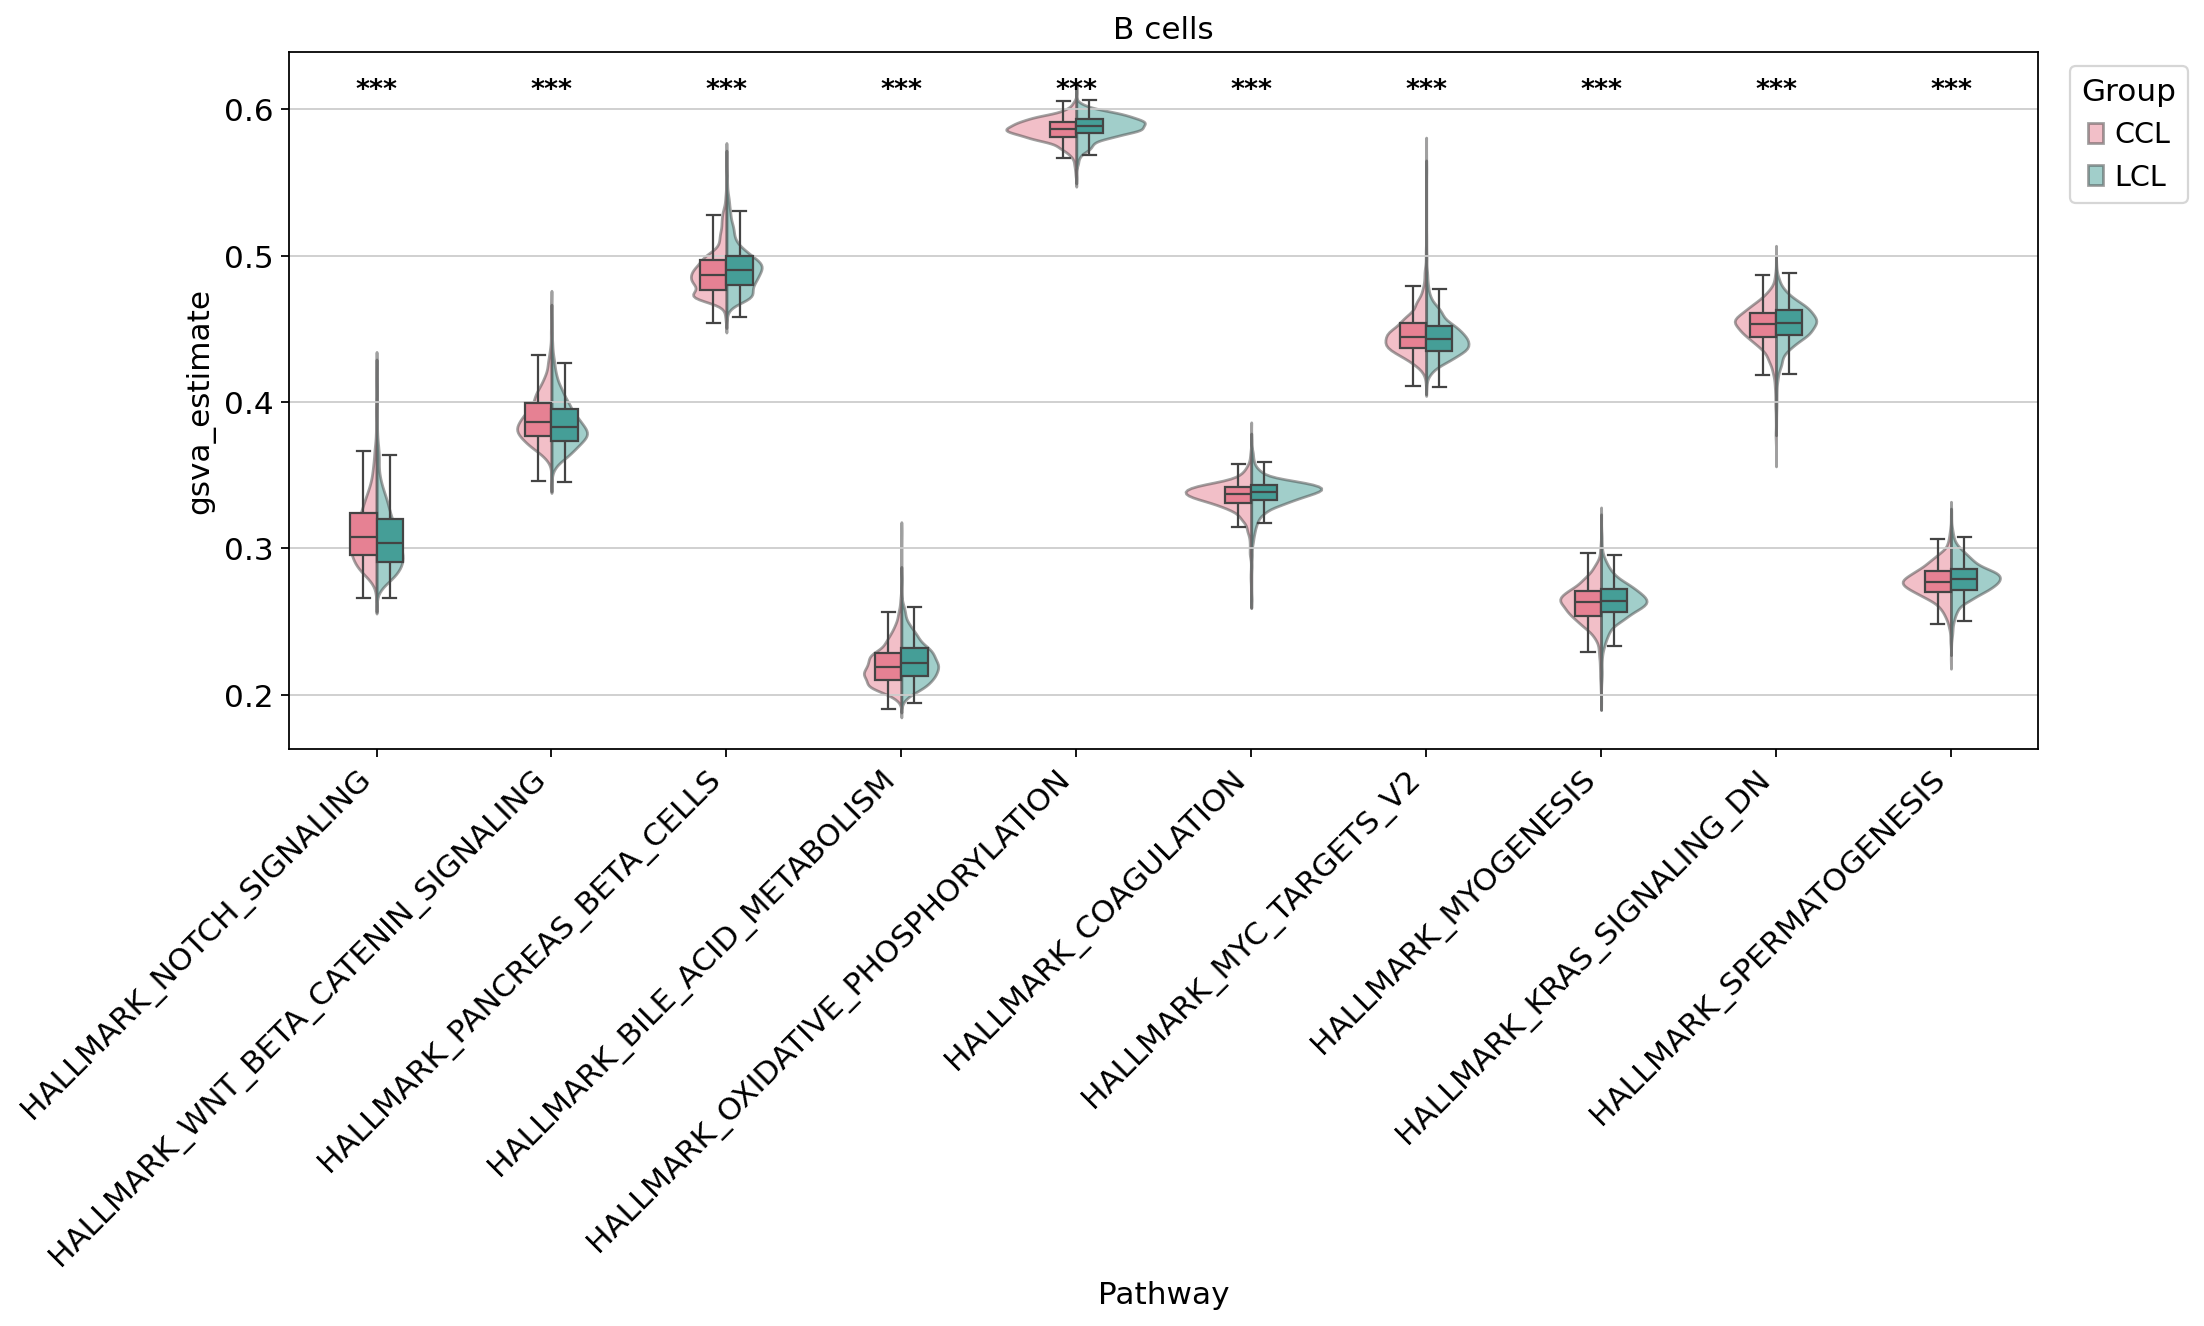

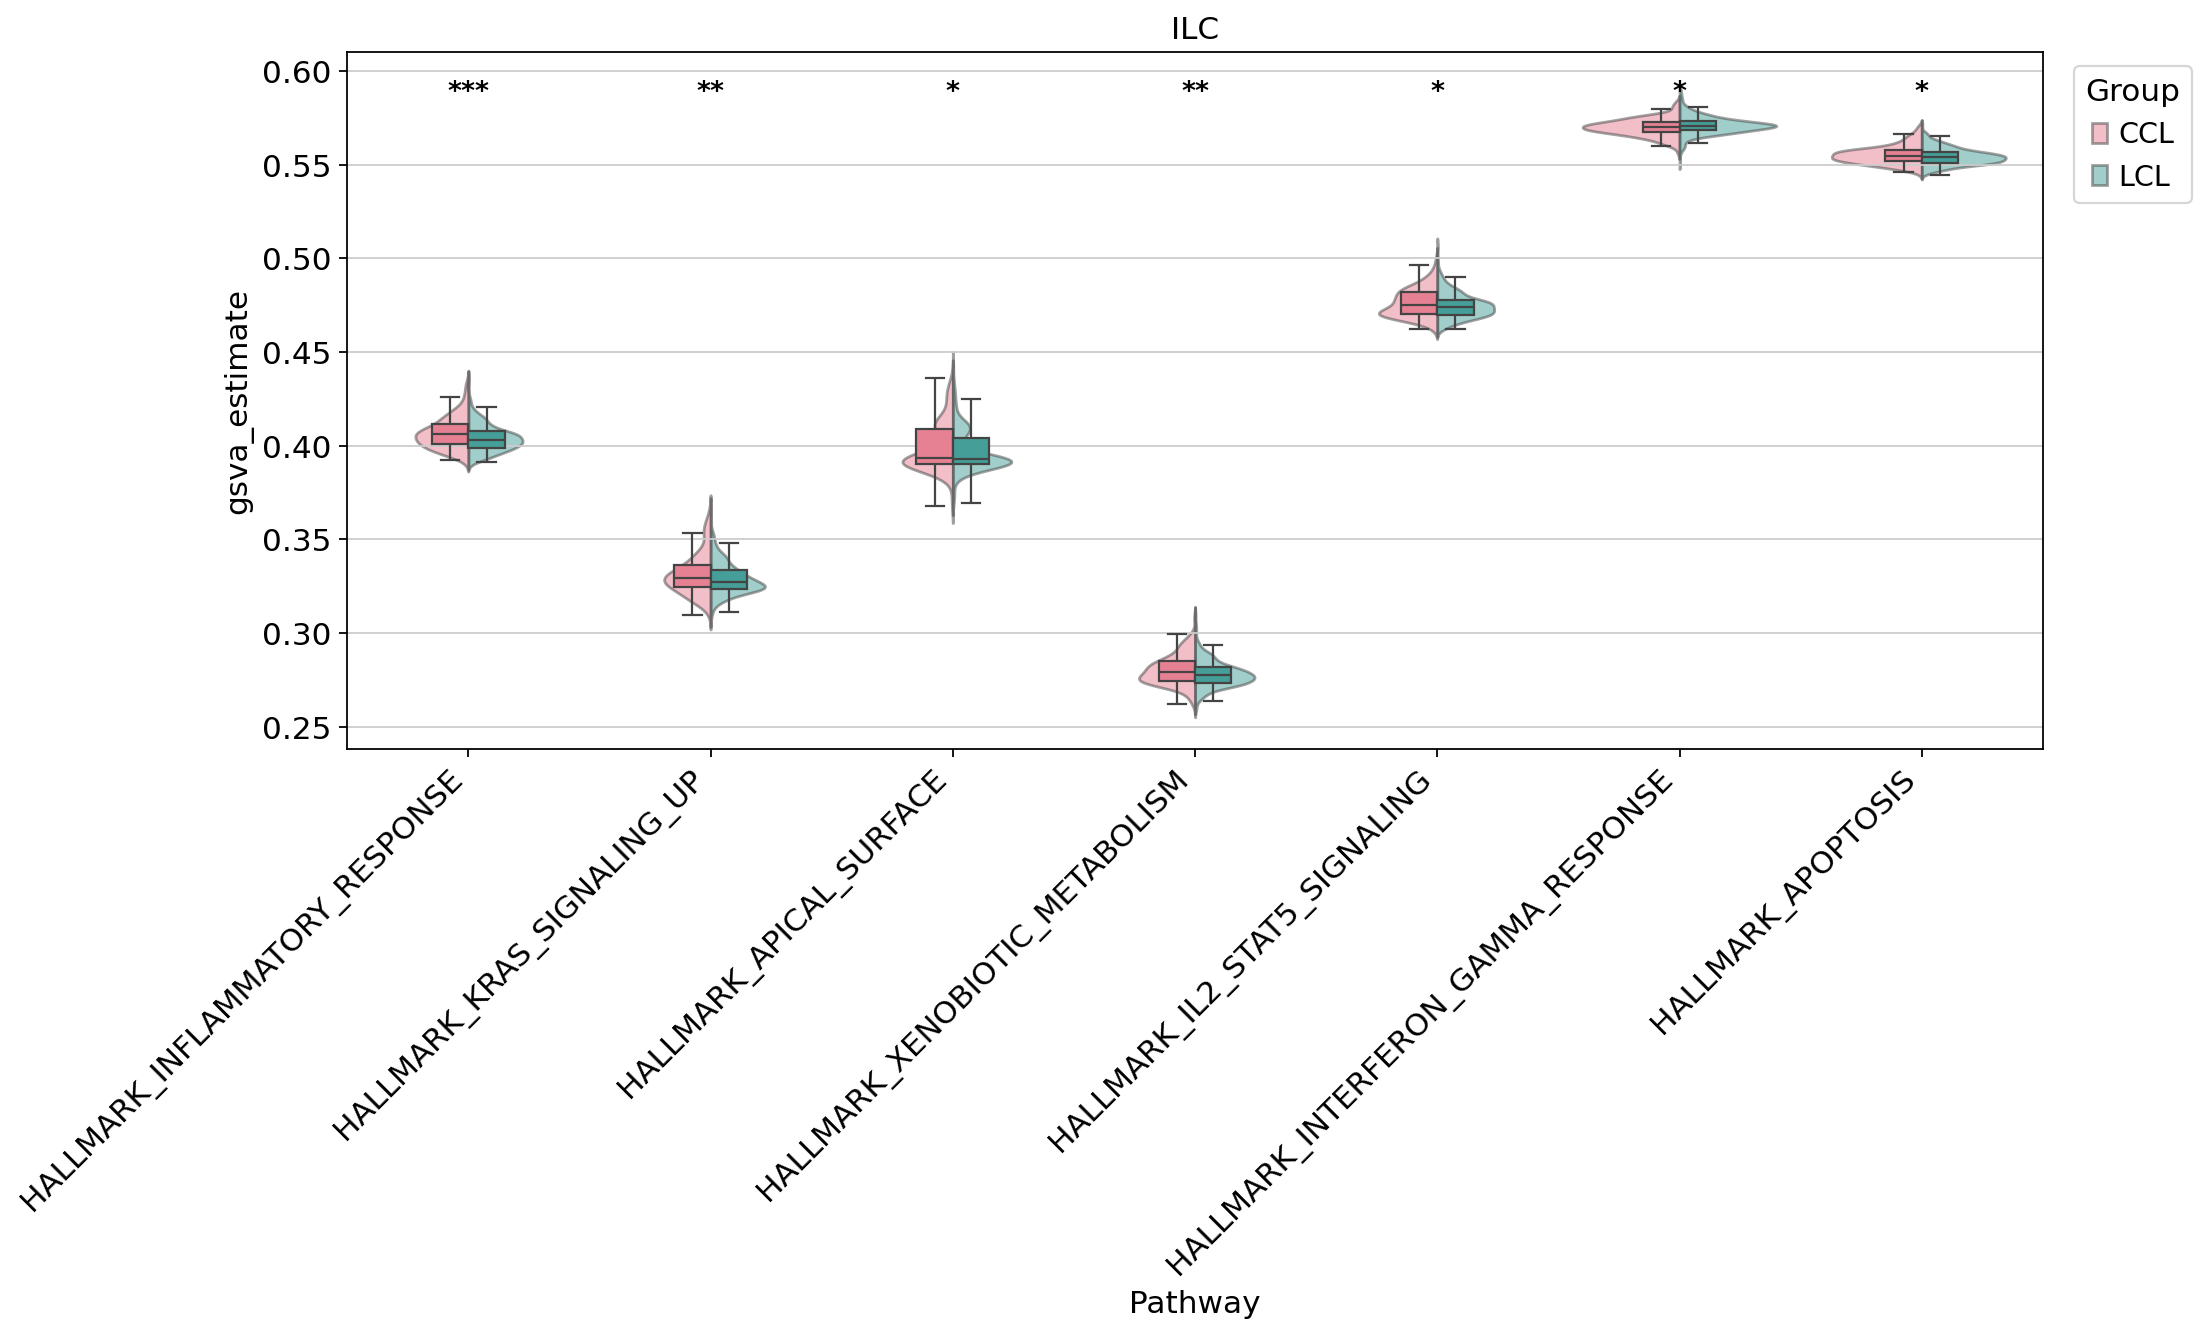

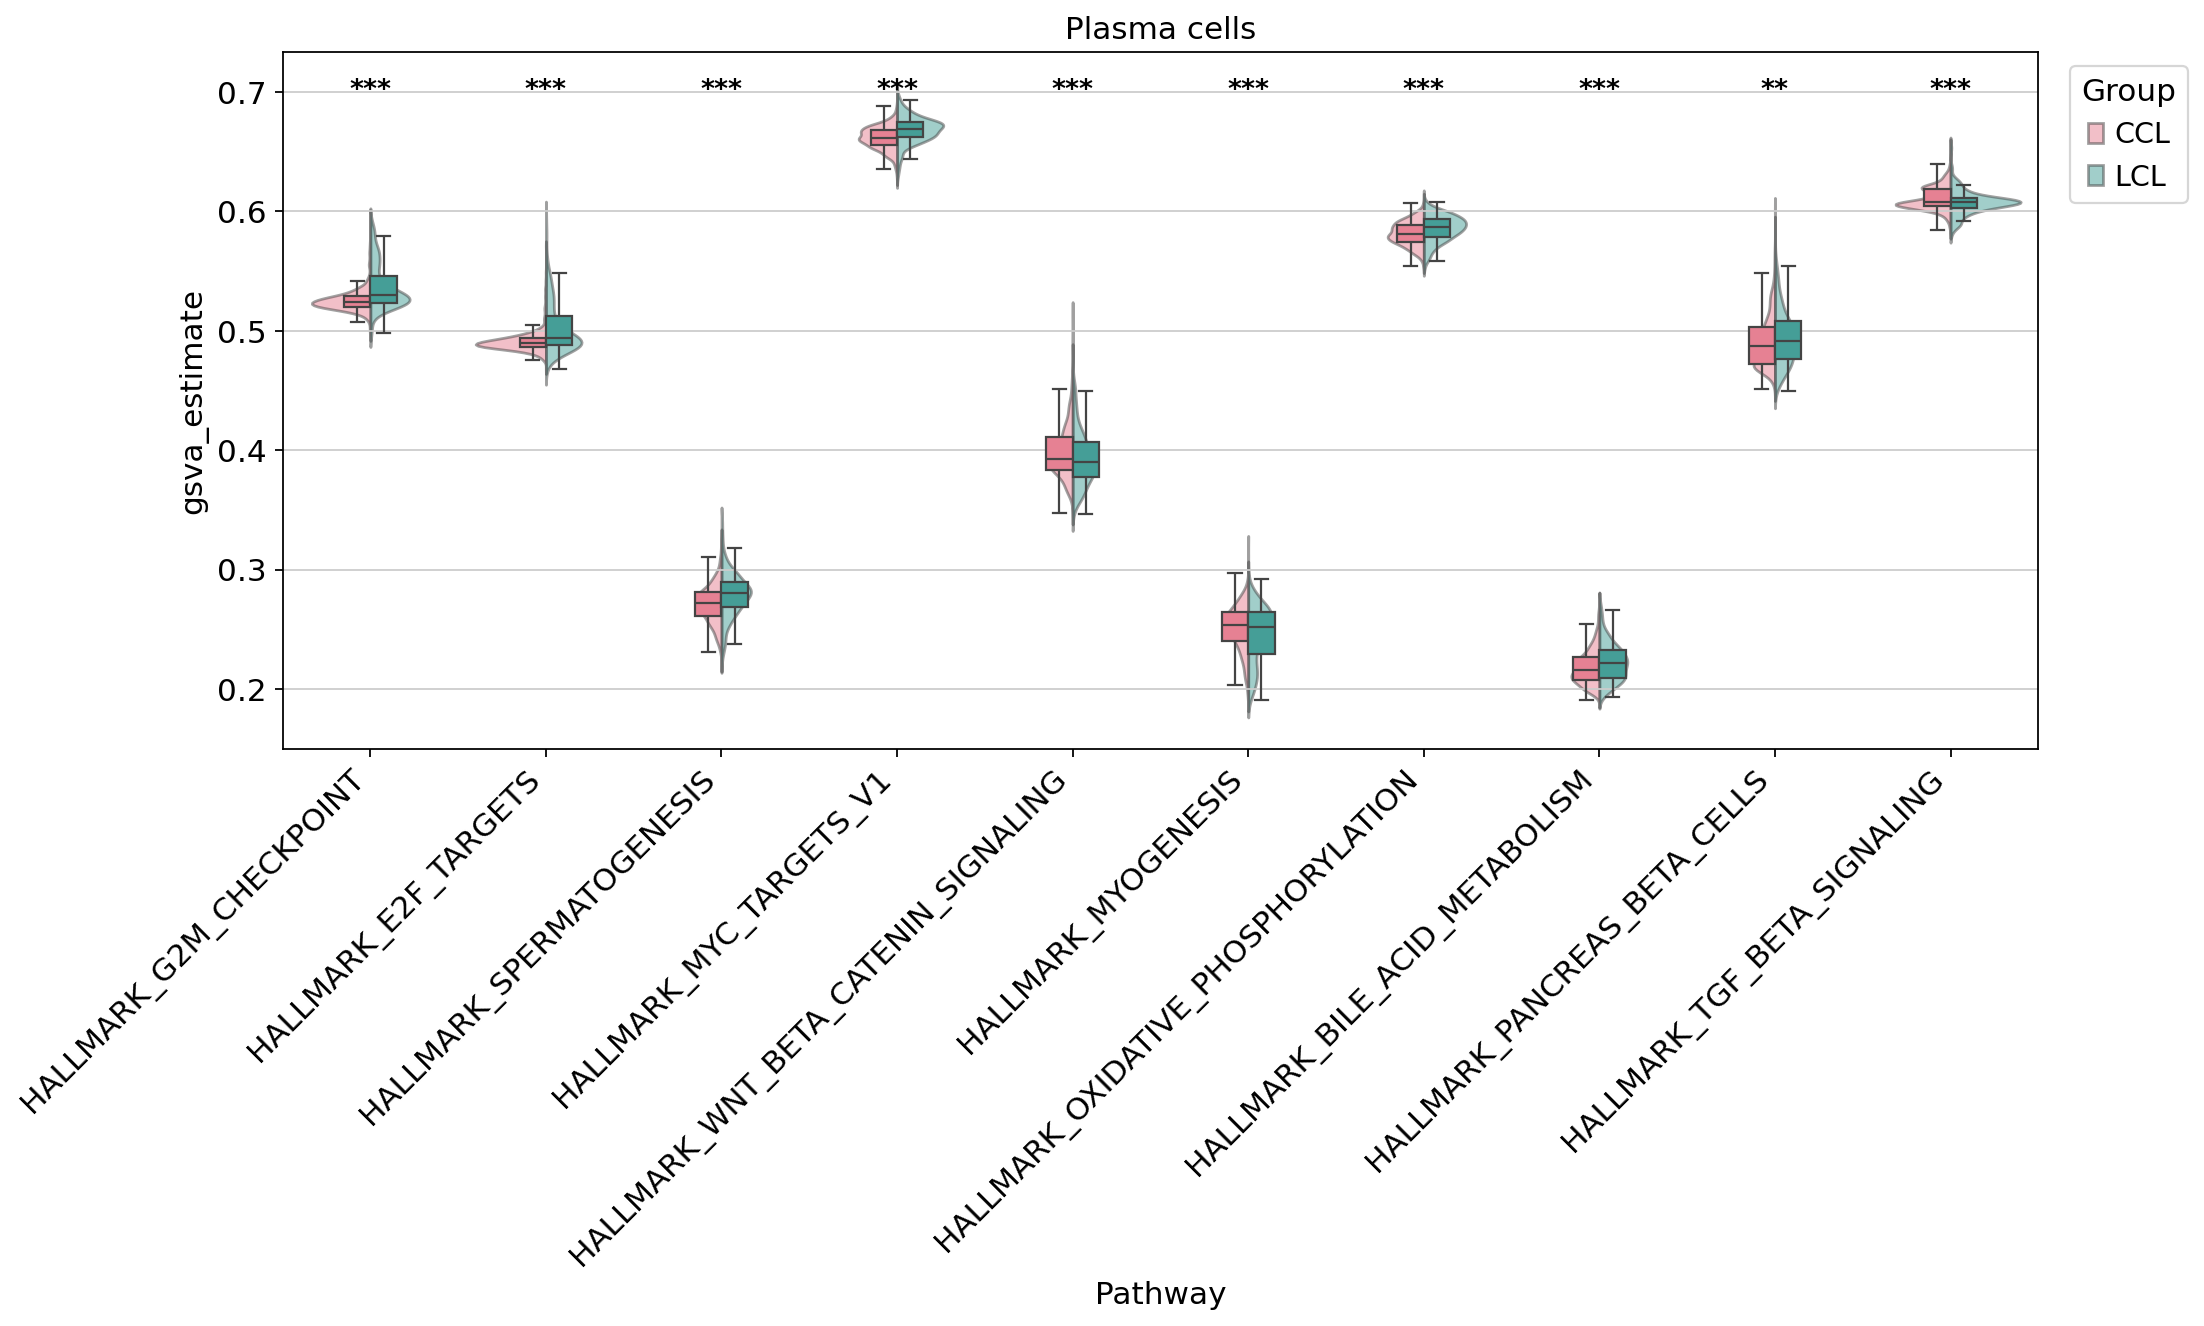

In [ ]:
plot_gsva_violin_box(
    adata=adata,
    estimates=estimates,
    cell_type_col=ANNO_COL,
    group_col=GROUPs_COL,
    stim_group=STIM,
    control_group=CTROL,
    output_dir=sub_fig_dir,
    prefix=unique_prefix,
    show_significant_only=True,
    max_pathways=10
)